In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import sys, os, glob
import numpy as np
import subprocess

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

# Analyzing the Gutenberg Books Corpus

The [Gutenberg Project](http://www.gutenberg.org/) is a collection of free books available online. In this lab we will use it to learn how to do analysis on text-based key-value datasets. 

Our ultimate goal in this lab is to produce something like the [Google Ngram Viewer](https://books.google.com/ngrams) but for the Gutenberg book corpus. 

The structure of this lab is as follows:

1. basic inspection of data using Spark
2. using basic Spark functions like `reduceByKey` to perform aggregations - how many authors are there? How many unique words?
3. transforming the data - vectorizing text documents
4. creating an N-gram viewer

## Starting up the Spark runtime: initializing a `SparkContext` 

In [2]:
import getpass
import pyspark
conf = pyspark.conf.SparkConf()
conf.setMaster('yarn')
conf.setAppName('gutenberg-{0}'.format(getpass.getuser()))
conf.set('spark.executor.memory', '4g')
conf.set('spark.executor.instances', '4')
sc = pyspark.SparkContext.getOrCreate(conf)
conf = sc.getConf()
sc

<SparkContext master=yarn appName=gutenberg-roskar>

## The data

The Gutenberg corpus has already been ingested and pre-processed for you. It is saved on HDFS as an RDD of `(book_id, text)` key-value pairs. In a separate data file, we saved a dictionary which contains the metadata for all the books in the RDD. 

## Load the data from HDFS

In [3]:
gutenberg_rdd = sc.sequenceFile('/datasets/gutenberg/gutenberg_rdd').setName('gutenberg_rdd').cache()

Lets quickly have a look at what this data looks like. These inspection methods are critical for getting a handle of the data in Spark - you will use them often!

In [4]:
gutenberg_rdd.first()

('15266',
 'The Project Gutenberg eBook, What Peace Means, by Henry van Dyke\n\n\nThis eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.net\n\n\n\n\n\nTitle: What Peace Means\n\nAuthor: Henry van Dyke\n\nRelease Date: March 5, 2005  [eBook #15266]\n\nLanguage: English\n\nCharacter set encoding: ISO-8859-1\n\n\n***START OF THE PROJECT GUTENBERG EBOOK WHAT PEACE MEANS***\n\n\nE-text prepared by Juliet Sutherland, Melissa Er-Raqabi, and the Project\nGutenberg Online Distributed Proofreading Team (http://www.pgdp.net)\n\n\n\nWHAT PEACE MEANS\n\nby\n\nHENRY VAN DYKE\n\nNew York          Chicago\nFleming H. Revell Company\nLondon    and   Edinburgh\n\n1919\n\n\n\n\n\n\n\nTo\nMy Son in the Faith\nMy Brother in the Work\nTertius van Dyke\n\n\n\n\nFOREWORD\n\nThis little book contains three plain sermons

No surprises there - the first element of the tuple is an ID string and the second element is the book text. 

How many books do we have total?

In [5]:
gutenberg_rdd.count()

18296

Check the line a few cells above where we loaded the data from HDFS - notice the `cache()` at the end. This means that we asked Spark to try and put as much of the RDD as possible into memory. It's not always possible to store all the data in memory, in which case Spark will periodically drop parts of RDDs and need to recompute or reload them. 

* Check the Spark UI (find the link in the second cell of this notebook) and find the `Storage` tab 
* What fraction of the `gutenberg_rdd` is cached? 

Notice another piece of information on the storage tab -- `Cached Partitions`. The RDD is split into "partitions", each partition consisting of many pieces of data in this case the `(ID, text)` tuples. Spark distributes computation by distributing the partitions among the executors.

![spark-rdd](../figs/spark-rdd.png)

The "driver" in this case is this notebook -- it communicates with the workers via the `SparkContext` and the RDD methods. 

### Load in the metadata dictionary and broadcast it

The metadata is saved as a dictionary on disk. If we want to use the metadata along with the RDD, we need to ship the metadata to the workers as well. In Spark, the best way to achieve this is via "broadcasting" - the metadata lookup table (dictionary in this case) is sent to the workers via a torrent mechanism and stored in each worker's RAM. There, it can be quickly retrieved for computation. 

Note that each worker holds *all* of the broadcast metadata, but only a subset of the partitions.

In [6]:
import json

with open('../data/gutenberg_metadata.json', 'r') as f :
    meta = json.load(f)

The metadata object is just a normal python dictionary, keyed by book `gid`. For example, the metadata for the book with `gid` 101 looks like:

In [7]:
meta['101']

{'author_id': '66',
 'author_name': ['Sterling', ' Bruce'],
 'birth_year': '1954',
 'death_year': None,
 'downloads': '239',
 'first_name': 'Bruce',
 'gid': '101',
 'language': 'en',
 'last_name': 'Sterling',
 'license': 'Copyrighted. Read the copyright notice inside this book for details.',
 'subtitle': '',
 'title': 'The Hacker Crackdown: Law and Disorder on the Electronic Frontier'}

We now ship the metadata to all of the workers:

In [8]:
# create meta_b by broadcasting meta_dict
meta_b = sc.broadcast(meta)

Remember that our `gutenberg_rdd` contains `gid`'s as keys and text as values and if we want some other piece of metadata, we can just access it via the lookup table, for example to extract the first names of the authors, we can do something like this: 

In [9]:
gutenberg_rdd.map(lambda x: meta_b.value[x[0]]['first_name']).first()

'Henry'

### Histogram of book publication years
Now we're ready to start asking some questions of the data. To begin with, lets do a simple histogram of the year distribution of the books. Since we don't have original publication dates, we just use the simple formula: 

$year = max\left((year_{birth} + year_{death})/2, year_{birth} + offset\right)$, 

where $offset$ is a number drawn from a gaussian centered on 40 with $\sigma = 5$ years. This means that we assume most people write their books around age 40. ;)

The function `publication_year` is provided for you and you should use it to *transform* the `year_rdd` into an RDD of publication years. 


In [10]:
from random import gauss

def publication_year(gid) : 
    """Returns the publication year for the given gutenberg id (gid)"""
    
    # extract the metadata dictionary for this gid
    meta = meta_b.value[gid] 
    
    birth_year = int(meta['birth_year'])
    if meta['death_year'] is None : 
        year = birth_year + gauss(40,5)
    else :
        death_year = int(meta['death_year'])
        year = max((birth_year + death_year) / 2.0, birth_year + gauss(40,5))

    return min(int(year),2015)

In [11]:
# TODO: map gutenberg_rdd to contain just the publication years by using the publication_year function above
year_rdd = gutenberg_rdd.keys().map(publication_year)

In [12]:
year_rdd.take(5)

[1892, 1908, 1894, 1960, 1884]

Now lets use the built-in histogram RDD method to compute the year-frequency distribution. We'll make a function to do the actual plotting.

Remember to check the Spark UI `Stages` tab to see what's happening! Can you see how large individual partitions are in bytes? How long does each one take to process?

In [13]:
def plot_histogram(rdd, nbins=100, logy=False):
    """Plot a histogram of values in an RDD"""
    hist = rdd.histogram(nbins)
    bins = np.array(hist[0])
    bins = 0.5*(bins[:-1]+bins[1:])
    vals = np.array(hist[1])

    plt.plot(bins, vals)
    plt.xlabel('year'); plt.ylabel('count');
    if logy:
        plt.semilogy();

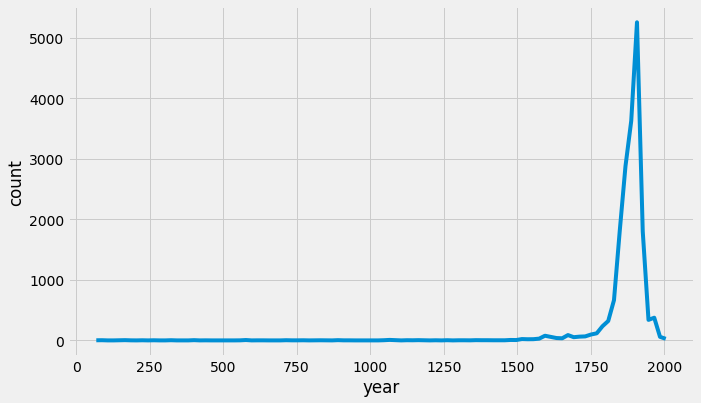

In [14]:
plot_histogram(year_rdd)

It's clear we have very few books before 1750. Lets filter the `year_rdd` to only include years after 1750 and produce the histogram again.

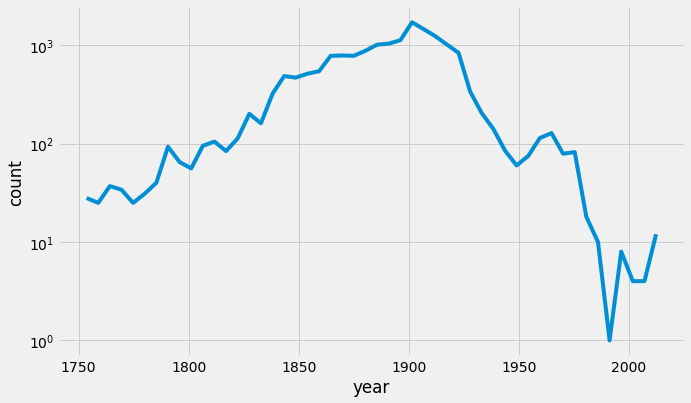

In [15]:
# TODO: filter the year_rdd to only include years after 1750
plot_histogram(year_rdd.filter(lambda year: year>1750), nbins=50, logy=True)

If you're playing around with the year ranges or the binning you will have noticed that this plot takes a while to generate. How could you speed it up? 

Hint: which data would be very cheap to cache?

### Inspecting the metadata some more

Lets do a couple more checks and practice using the Spark API. 

#### How many unique authors are there in the dataset? 

1. make `author_rdd` that is composed of a string `"last_name, first_name"` (use the broadcast variable `meta_b` to get the data for each `gid`)
2. keep only the unique author strings (*hint*: look at the [Spark RDD API](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) to find an appropriate method)
3. count the number of elements remaining

**note**: use `meta_b.value` to access the actual metadata dictionary, i.e. to get the metadata for `gid=101`:

In [16]:
meta_b.value['101']

{'author_id': '66',
 'author_name': ['Sterling', ' Bruce'],
 'birth_year': '1954',
 'death_year': None,
 'downloads': '239',
 'first_name': 'Bruce',
 'gid': '101',
 'language': 'en',
 'last_name': 'Sterling',
 'license': 'Copyrighted. Read the copyright notice inside this book for details.',
 'subtitle': '',
 'title': 'The Hacker Crackdown: Law and Disorder on the Electronic Frontier'}

In [17]:
# TODO: map gutenberg_rdd to contain the string "last_name, first_name" 
# note: make sure you use strings here and not lists of strings for author names
author_rdd = gutenberg_rdd.map(lambda doc: '{0}, {1}'.format(meta_b.value[doc[0]]['last_name'], meta_b.value[doc[0]]['first_name']))

In [18]:
# TODO: use RDD methods to obtain the distinct author name strings and count them
n_authors = author_rdd.distinct().count()
print("Number of distinct authors: %s " % n_authors)

Number of distinct authors: 7017 


In [19]:
assert(n_authors == 7017)

#### Most-represented authors in the corpus: 

Here we will use a very common map/reduce pattern to count the number of occurrences of a key. The trick is to transform the RDD into key-value pairs of `(key, 1)`. For example, we might have an RDD like:

    [('a', 1),
     ('b', 1), 
     ('c', 1), 
     ('a', 1), 
     ('b', 1)]

If we fed this RDD to `reduceByKey` and used the simple `add` operator (see the spark intro notebook) we would get back something like

    [('a', 2), ('b', 2), ('c', 1)]

1. use the `author_rdd` from above
2. use the pattern `(key, 1)` to set up an RDD that can be passed to [`reduceByKey`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey)
3. run `reduceByKey`, yielding an RDD composed of `(author, count)` tuples
4. sort by descending order of number of books per author and print out the top 10 (try using [`takeOrdered`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.takeOrdered))

In [20]:
# TODO: generate a list of top 20 authors, reverse-sorted by the number of books they have in the corpus
(author_rdd.map(lambda x: (x,1))
           .reduceByKey(lambda a, b: a+b)
           .sortBy(lambda x: -x[1])
           .take(10))

[('Balzac, Honoré de', 121),
 ('Kingston, William Henry Giles', 113),
 ('Twain, Mark', 104),
 ('Ballantyne, R. M. (Robert Michael)', 95),
 ('Jacobs, W. W. (William Wymark)', 94),
 ('Pepys, Samuel', 85),
 ('Fenn, George Manville', 83),
 ('Shakespeare, William', 82),
 ('Dumas, Alexandre', 73),
 ('Verne, Jules', 72)]

Finally, lets do the same thing per language, just to get an idea of how much data there is: 

In [21]:
# TODO: generate a lang_rdd that contains just the language of each book
lang_rdd = gutenberg_rdd.keys().map(lambda gid: meta_b.value[gid]['language'])

In [22]:
# TODO: reduce the `lang_rdd` to yield the number of books in each language
(lang_rdd.map(lambda x: (x,1))
         .reduceByKey(lambda a,b: a+b)
         .sortBy(lambda x: -x[1])
         .collect())

[('en', 14921),
 ('fr', 1171),
 ('fi', 461),
 ('nl', 329),
 ('pt', 312),
 ('de', 299),
 ('es', 198),
 ('it', 167),
 ('zh', 155),
 ('eo', 50),
 ('sv', 48),
 ('tl', 34),
 ('la', 26),
 ('pl', 20),
 ('ca', 19),
 ('da', 18),
 ('el', 13),
 ('hu', 10),
 ('no', 10),
 ('cs', 6),
 ('cy', 3),
 ('ru', 3),
 ('sr', 3),
 ('af', 2),
 ('enm', 2),
 ('is', 2),
 ('nah', 2),
 ('fy', 1),
 ('he', 1),
 ('gl', 1),
 ('kha', 1),
 ('ia', 1),
 ('ceb', 1),
 ('fur', 1),
 ('gla', 1),
 ('nap', 1),
 ('nai', 1),
 ('oc', 1),
 ('kld', 1)]

## How many unique words were used in English in these 500+ years? 

We could have done the above metadata gymnastics without ever invoking a distributed processing framework by simply extracting the years from the metadata dictionary of course -- nevertheless we used the metadata to have a closer look at some of the RDD methods. However, the actual text of each data element is where the bulk of the data volume lies. 

To construct a corpus wide vocabulary, we have to deconstruct each document into a list of words and then extract the unique words from the entire data set. If our dataset fits into memory of a single machine, this is a simple `set` operation. But what if it doesn't? 

We'll assume the latter is the case and construct one global RDD of words. Here we aren't necessarily interested in preserving the provenance of words, but just finding the unique words in the whole corpus, so we drop the metadata altogether. 

### The steps are as follows:

1. remove punctuation from the text (a `remove_punctuation` function has been created for you below)
2. make the text lowercase (use the `lower()` method of python strings)
1. map the entire RDD of text into an RDD of single words (you need to use [flatMap](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.flatMap) -- this returns a different number of elements than it takes in)
2. use the `distinct` method of the resulting RDD to transform it into an RDD with only unique words

Here's an illustration of how **`flatMap`** differs from **`map`**:

![flatMap](../figs/flatMap_example.svg)

<div class="alert alert-info">
<p><strong>Hint</strong></p> 
<p>In python, splitting a string into a set of words separated by spaces is easy: </p>
</div>

In [23]:
line = 'splitting a string is super simple'
line.split()

['splitting', 'a', 'string', 'is', 'super', 'simple']

In [24]:
# here we define a function that strips out all punctuation
import re
import string

def remove_punctuation(text): 
    """Return text without punctuation"""
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    return regex.sub('', text)

In [25]:
# for example:
remove_punctuation('This! Is, A; Punctuated- Sentence/')

'This Is A Punctuated Sentence'

In [26]:
# TODO: define `english_rdd` which should contain only english-language books -- we will need this again later
# hint: check whick keys are available in `meta_b.value`
english_rdd = gutenberg_rdd.filter(lambda doc: meta_b.value[doc[0]]['language'] == 'en')

In [27]:
# TODO: define `distinct_rdd` which should contain all lowercase, unique words in the english books of the corpus
distinct_rdd = (english_rdd.values() # this is a quick way to get rid of the keys since we don't need them anymore
                           .map(remove_punctuation)
                           .flatMap(lambda text: text.lower().split())
                           .distinct())
nwords = distinct_rdd.count()
print("Number of unique English words: ", nwords)

Number of unique English words:  4486584


In [28]:
distinct_rdd.take(20)

['is',
 '15266',
 'presbyterian',
 'beauty',
 'always',
 'imperishable',
 'truly',
 'labour',
 'interruptions',
 'france',
 'accused',
 'voyage',
 'refuge',
 'hidden',
 'trying',
 'selfishness',
 'down',
 'lips',
 'walk',
 'compliance']

Of course not all of these are actual words, this is just how many character sequences separated by spaces we found. The pre-processing steps are less than perfect so there is some garbage in there. We will trim this down to just the most commonly-used ones later and that will get rid of most of the nonsense. 

## What are the most common words? 

A "map/reduce" tutorial has to include a word counting example -- it's basically the equivalent of a "Hello World!" in programming!

So, lets count the occurences of all the words across the entire corpus. This is a fairly straightforward operation, but it exposes some very common patterns that can be useful for many tasks. To simplify this a bit, we'll use only the English-language corpus for the moment.

Here are the steps we need to take:

0. keep only the english language books (use a filter)
1. `flatMap` each document into (`word, count`) pairs, but only for words that are not in the `stop_words` set (try with a list comprehension!)
2. call `reduceByKey` to sum up all the `count`s for each word
3. finally sort it in descending order to see the most common words first

The first part here (filtering and `flatMap`) is much like what we did before, but with a twist: for each word, check that it is *not* a member of the `stop_words` set. "Stop words" include common words like "a, the, he" etc.  

In [29]:
from pickle import load
with open('../data/stop_words.dump', 'rb') as f:
    stop_words = load(f).union(['gutenbergtm', 'gutenberg', 'electronic', 'foundation', 'license', 'copyright', 'donation', 'donations'])
stop_words_b = sc.broadcast(stop_words)

In [30]:
# TODO: use flatMap to extract the words from each document's text using the english_rdd we made above
#       Don't forget to make everything lowercase, remove the punctuation, and filter out the stop words!

words_rdd = (english_rdd.values()
                        .map(remove_punctuation)
                        .flatMap(lambda text: text.lower().split())
                        .filter(lambda word: word not in stop_words_b.value)
                        .setName('words_rdd'))

Now that we have our "flattened" data set, do the counting by:

1. mapping each word in `words_rdd` into a `(word, 1)` tuple 
2. using `reduceByKey` to calculate the word frequencies 
3. using the `sortBy` method to sort the word counts in descending order

In [31]:
# TODO: do the word count!
# Note that we subsample the dataset a bit in the first step here to make the calculation a little faster
word_count = (words_rdd.sample(False, 0.2) 
                       .map(lambda word: (word, 1))
                       .reduceByKey(lambda a,b: a+b)
                       .sortBy(lambda x: -x[1])
                       .setName('word_count')
                       .cache())

In [32]:
assert(word_count.keys().take(5) == ['said', 'man', 'time', 'little', 'like'])

### Top 100 most common words

In [33]:
word_count.take(100)

[('said', 581598),
 ('man', 333958),
 ('time', 320766),
 ('little', 296737),
 ('like', 283942),
 ('did', 276733),
 ('project', 273130),
 ('work', 258950),
 ('great', 257125),
 ('know', 231207),
 ('mr', 217480),
 ('old', 216481),
 ('good', 216403),
 ('come', 210848),
 ('men', 209049),
 ('way', 197355),
 ('came', 192549),
 ('life', 190250),
 ('day', 185651),
 ('long', 182942),
 ('make', 176823),
 ('say', 170840),
 ('think', 162033),
 ('shall', 161629),
 ('new', 154923),
 ('away', 154921),
 ('just', 154291),
 ('people', 151956),
 ('thought', 150482),
 ('went', 149287),
 ('eyes', 144271),
 ('hand', 139236),
 ('place', 137823),
 ('dont', 137752),
 ('right', 136883),
 ('young', 127909),
 ('house', 127769),
 ('years', 125022),
 ('works', 122625),
 ('face', 121855),
 ('things', 118763),
 ('left', 118618),
 ('head', 116549),
 ('let', 114477),
 ('saw', 112815),
 ('world', 112814),
 ('tell', 110061),
 ('took', 108236),
 ('night', 107993),
 ('love', 107809),
 ('far', 106127),
 ('sir', 105278),
 ('

# Computing word frequency vs. time

Now we have all the components to build a simple tool that visualizes the relative word frequency as a function of time in the Gutenberg corpus. For inspiration, see the [Google Ngram viewer](https://books.google.com/ngrams).

### Converting documents into vectors

To make quantitative analysis of the corpus possible, we will convert each document into a vector that represents the word counts for each word appearing in the document. 

This will look something like this. Imagine we have have a corpus consisting of two "documents"

    document 1: "a dog bit me"
    document 2: "i bit the dog back"
    
Then our corpus vocabulary (of 1-grams) is

    ["a", "dog", "bit", "me", "i", "the", "back"]
    
Since this is an array and each word in the array has a unique index, we can "encode" the two documents using this index mapping. Our corpus now looks like this: 

    document 1: [1, 1, 1, 1, 0, 0, 0]
    document 2: [0, 1, 1, 0, 1, 1, 1]
    
In order for the vector indices to remain consistent across the whole corpus, the first step is to build a corpus-wide lookup table, a `word --> index` mapping. 


### Generating word counts 

Once each document is converted to a vector, doing the word counts for sub-groups of documents is a simple vector addition operation. In our case, we will reduce the vectors by year, yielding an RDD that will have the total number of occurrences of each word in every year. From there, it is trivial to look up the desired word and plot the relative frequency vs. year. 

## Create the vocabulary lookup table
Create a look-up table of words by attaching a unique index to each word. The Spark API provides a [zipWithIndex](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.zipWithIndex) method that makes this easy. 

Above, we created the `word_count` RDD that already contains the unique words and their associated counts. To reduce the size of the lookup table (and the size of the vectors), we will restrict ourselves to using only the first 100k words. 

You can either create the `(word, index)` pairs in the RDD and collect the top 100,000 as a dictionary using `collectAsMap`, or you can collect the top 100,000 words from `word_count` RDD and turn them into a dictionary locally. 

These are the steps we need to take to make the vocabulary lookup from an RDD:

1. use `zipWithIndex` on the keys of `word_count` to generate a unique index for each word -- we don't care about the counts anymore, so we can get rid of the values and just work with the keys using the `keys()` method
2. use filter to retain only the first 100000 words 
3. finally, use [collectAsMap](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collectAsMap) to return the resulting RDD to the driver as a dictionary. 

In [34]:
# TODO: create word_lookup, a dictionary that maps each of the top 100,000 words to a unique integer
word_lookup = word_count.keys().zipWithIndex().filter(lambda x: x[1]<100000).collectAsMap()

Make a `word_lookup` into a broadcast variable so we can use it on all the workers:

In [35]:
word_lookup_b = sc.broadcast(word_lookup)

This dictionary is approximately 6 Mb in size - without a broadcast, it would get sent over the network to each task, resulting in a lot of network traffic! As a broadcast variable, it gets sent only *once* to each *executor*, i.e. it's transferred only 20 times (if you are using the defaults, otherwise however many executors you have). 

## Vectorize the documents

Now that we have a vocabulary lookup table, we can use this to turn each document into a vector. 

This is done by counting up the occurrences of all words in the document that are also in the global vocabulary. 

The function `vectorize_doc` below accomplishes this by using a dictionary to keep track of the local word count. Once the counting is done we use the counts to create a sparse vector that represents the document. A sparse vector consists of two arrays, one representing the *locations* of the non-zero values, and the other the values themselves. 

To return to our contrived example from above, we had 

    document 1: "a dog bit me"
    document 2: "i bit the dog back"
    
which turned into 

    document 1: [1, 1, 1, 1, 0, 0, 0]
    document 2: [0, 1, 1, 0, 1, 1, 1]

with a vocabulary of 

    ["a", "dog", "bit", "me", "i", "the", "back"]
    
As sparse vectors, these two documents could be represented with two arrays: 

    document 1: indices = [0,1,2,3]; values = [1, 1, 1, 1]
    document 2: indices = [1,2,4,5,6]; values = [1, 1, 1, 1, 1]

We use Spark's own `SparseVector` data type, for which we must specify a size (total number of features), a (sorted) array of indices, and an array of values. This means that we start to save space if sparsity is > 50%. Note that the `SparseVector` provides some nice higher-level methods, but it does not allow simple operations like addition. If a lot of vector arithmetic is needed, you should use the scipy sparse types instead. 

In the next cell, we define two functions: 

* **`extract_ngrams`** converts a sequence of words or characters into a sequence of n-grams (here we are just using single worde, i.e. 1-grams so we'll postpone talking about ngrams until later)

* **`vectorize_doc`** converts a document into a sparse vector by using `extract_ngrams` to tokenize it and a vocabulary mapping to turn each word into a vector component

In [36]:
from pyspark.mllib.linalg import SparseVector

def extract_ngrams(tokens, ngram_range=[1,1], select_ngrams = None, ngram_type='word'):
    """
    Turn tokens into a sequence of n-grams 

    Arguments:

        tokens: a list of tokens

    Optional Keywords:

        ngram_range: a tuple with min, max ngram ngram_range
    
        select_ngrams: the vocabulary to use
    
        ngram_type: whether to produce word or character ngrams

    Output:

    Generator yielding a list of ngrams in the desired range
    generated from the input list of tokens

    """
    join_str = "" if ngram_type=='character' else " "
    
    # handle token n-grams
    min_n, max_n = ngram_range
    n_tokens = len(tokens)
    
    for n in range(min_n, min(max_n + 1, n_tokens + 1)):
        for i in range(n_tokens - n + 1):
            if n == 1: 
                res = tokens[i]
            else : 
                res = join_str.join(tokens[i: i+n])
           
            # if we are using a lookup vocabulary, check for membership here
            if select_ngrams is not None : 
                if res in select_ngrams: 
                    yield res
            else : 
                yield res
            

def vectorize_doc(doc, vocab, ngram_range = [1,1], ngram_type='word') : 
    """
    Returns a vector representation of `doc` given the reference 
    vocabulary `vocab` after tokenizing it with `tokenizer`
    
    Arguments: 
        
        doc: a sequence of tokens (words or characters)
        
        vocab: the vocabulary mapping
        
    Keywords:
    
        ngram_range: the range of ngrams to process
        
        ngram_type: whether to produce character or word ngrams; default is 
        
    Returns:
    
        a sparse vector representation of the document given the vocabulary mapping
    """
    from collections import defaultdict
    from scipy.sparse import csr_matrix 
        
    # count all the word occurences 
    data = np.zeros(len(vocab))
    
    for ngram in extract_ngrams(doc, ngram_range, vocab, ngram_type) : 
         data[vocab[ngram]] += 1
            
    # only keep the nonzero indices for the sparse representation
    indices = data.nonzero()[0]
    values = data[indices]
    
    return SparseVector(len(vocab), indices, values)

Using these functions to vectorize our two-sentence test corpus: 

In [37]:
import string
s1 = "a dog bit me"
s2 = "i bit the dog back"
vocab = ["a", "dog", "bit", "me", "i", "the", "back"]
vocab_dict = {word:ind for ind, word in enumerate(vocab)}

In [38]:
print(s1)
print(vectorize_doc(s1.split(), vocab_dict))
print(s2)
print(vectorize_doc(s2.split(), vocab_dict))

a dog bit me
(7,[0,1,2,3],[1.0,1.0,1.0,1.0])
i bit the dog back
(7,[1,2,4,5,6],[1.0,1.0,1.0,1.0,1.0])


Now we have all the components we need to create an RDD of english-language books vectorized using the most common 100k words. All we need to do is to use `mapValues` to map the text of each document in `english_rdd` into a vector using `vectorize_doc` and our broadcast vocabulary lookup table `word_lookup_b`. Recall that the broadcast variable, `word_lookup_b` is just a wrapper for the lookup table; to pass the actual lookup table to the `vectorize_doc` function, use `word_lookup_b.value`.

In [39]:
# TODO
vector_rdd = english_rdd.mapValues(lambda text: vectorize_doc(text.split(), word_lookup_b.value)).cache()

In [40]:
vector_rdd.take(5)

[('15266',
  SparseVector(100000, {0: 6.0, 1: 5.0, 2: 4.0, 3: 3.0, 4: 6.0, 5: 5.0, 7: 37.0, 8: 12.0, 9: 7.0, 11: 2.0, 12: 8.0, 13: 6.0, 14: 6.0, 15: 6.0, 16: 4.0, 17: 16.0, 18: 9.0, 19: 3.0, 20: 15.0, 21: 6.0, 22: 1.0, 23: 22.0, 24: 7.0, 25: 4.0, 26: 6.0, 27: 5.0, 28: 3.0, 29: 2.0, 30: 1.0, 32: 1.0, 34: 5.0, 35: 1.0, 37: 3.0, 38: 23.0, 39: 3.0, 40: 7.0, 41: 2.0, 43: 3.0, 44: 3.0, 45: 20.0, 46: 3.0, 47: 4.0, 48: 1.0, 49: 16.0, 50: 1.0, 52: 1.0, 53: 1.0, 56: 10.0, 57: 4.0, 58: 1.0, 59: 1.0, 60: 2.0, 61: 5.0, 62: 3.0, 63: 2.0, 64: 2.0, 65: 10.0, 66: 8.0, 67: 1.0, 68: 2.0, 69: 1.0, 70: 3.0, 71: 2.0, 72: 1.0, 73: 1.0, 74: 2.0, 76: 7.0, 77: 1.0, 79: 4.0, 81: 1.0, 83: 4.0, 86: 1.0, 87: 6.0, 90: 19.0, 92: 3.0, 94: 5.0, 96: 3.0, 97: 4.0, 99: 2.0, 101: 3.0, 102: 4.0, 103: 2.0, 105: 1.0, 106: 7.0, 108: 1.0, 112: 1.0, 118: 8.0, 119: 2.0, 120: 3.0, 121: 7.0, 122: 8.0, 123: 2.0, 126: 6.0, 130: 3.0, 132: 10.0, 134: 2.0, 136: 5.0, 137: 1.0, 140: 4.0, 141: 1.0, 142: 1.0, 143: 1.0, 144: 1.0, 145: 3.0, 1

In [41]:
# make sure the transformation can be carried out for all elements by using count
# this is a good way of catching anomalies in the data
vector_rdd.count()

14921

## Perform the aggregation

We now have the entire Gutenberg English book corpus in the form of sparse vectors encoding the most used 100k words. 

To get the yearly sums, we will turn the metadata of each document into its publication year (i.e. the key will be the year, the value is the vector) and then do an aggregation by year. 

We will use the powerful [`treeAggregate`](http://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=values#pyspark.RDD.treeAggregate) method, which requires that we specify three different components:

1. the starting aggregate
2. a function that adds a new value to the aggregate 
3. a function that adds together two aggregates

The way `treeAggregate` works is that it performs the reduction in a tree pattern in order to minimize the strain on the driver. In a "normal" reduction, the workers send their results to the driver, which is tasked with putting it all together -- however, if these partial results are large (as is potentially the case here) then the driver can run into memory issues. Furthermore, most of the cluster is sitting idle while the driver performs the aggregation. `treeAggregate` fixes this by performing partial aggregations on the workers and only sending the final stages to the driver. See this [blog post](https://databricks.com/blog/2014/09/22/spark-1-1-mllib-performance-improvements.html) for a bit more description of this method. 

The aggregation methods are powerful because the "aggregate" can be any object -- we can write a class that gets passed around to do the aggregation, for example. Aggregation methods are more general reduction methods because they allow you to change the type of the variables -- in our case here, we are converting the data `(year, vector)` tuples into a dictionary of arrays. 

Below, we will use an instance of a dictionary as the aggregation object and define two functions that will do the actual aggregation. 

In [42]:
def add_vector(d, data_tuple) : 
    """Add a new vector to the aggregation dictionary
    
    The vectors in the aggregation dictionary are dense since for most years we can expect that 
    this will be the case anyway. Note that we use 32-bit floats to save a bit on memory. 
    
    Arguments: 
        d: the aggregation dictionary
        
        data_tuple: the (year, vec) tuple
        
    Returns: 
        the updated aggregation dictionary 
    """
    # expand the data tuple
    year, vec = data_tuple
    
    if year in d : 
        
        d[year][vec.indices] += vec.values
    else :
        # this is the first time we've encountered this year --> make an empty vector 
        new_vec = np.zeros(vec.size, dtype=np.float32)
        
        # now put in the contents of the current vector
        new_vec[vec.indices] = vec.values
        
        # create the year in the dictionary
        d[year] = new_vec
        
    return d

def add_dicts(d1, d2) : 
    """Add two dictionaries together
    
    Arguments: 
        d1: first dictionary
        
        d2: second dictionary
        
    Returns: 
        merged dictionaries
    """
    
    # iterate through all the items in the second dictionary
    for year, vec in d2.items() : 
        # if this year is also in d1, add the vectors together
        if year in d1 : 
            d1[year] += vec
        # if not, create a new year entry in d1
        else : 
            d1[year] = vec
    return d1

Now we create an RDD of `(year, vec)` pairs using the `publication_year` function we defined at the top:

In [43]:
year_vec = vector_rdd.map(lambda doc: (publication_year(doc[0]), doc[1]))

Before we perform the aggregation, we can do one final bit of optimization. Passing around dictionaries full of large arrays can get expensive very quickly. The memory footprint of our partial results will depend on how heterogeneous the years on each partition or group of partitions are: if most of the data on a partition is for the same key (year in this case) then the dictionary we create on that partition will only contain a handful of vectors.  We can control this by first partitioning the RDD in a way that groups data with the same keys onto the same partitions. 

Spark provides a `partitionBy` method that does exactly this -- by default, it uses a hash function to map the keys to partitions, but you can also pass a custom partitioner if you want. If you look at the Spark UI after executing the next cell, you'll see that the partition step caused some shuffling of data, but that the aggregation itself ran very quickly and with minimal data movement. 

In [44]:
n_partitions = year_vec.getNumPartitions()

In [45]:
year_vec.first()

(1893,
 SparseVector(100000, {0: 6.0, 1: 5.0, 2: 4.0, 3: 3.0, 4: 6.0, 5: 5.0, 7: 37.0, 8: 12.0, 9: 7.0, 11: 2.0, 12: 8.0, 13: 6.0, 14: 6.0, 15: 6.0, 16: 4.0, 17: 16.0, 18: 9.0, 19: 3.0, 20: 15.0, 21: 6.0, 22: 1.0, 23: 22.0, 24: 7.0, 25: 4.0, 26: 6.0, 27: 5.0, 28: 3.0, 29: 2.0, 30: 1.0, 32: 1.0, 34: 5.0, 35: 1.0, 37: 3.0, 38: 23.0, 39: 3.0, 40: 7.0, 41: 2.0, 43: 3.0, 44: 3.0, 45: 20.0, 46: 3.0, 47: 4.0, 48: 1.0, 49: 16.0, 50: 1.0, 52: 1.0, 53: 1.0, 56: 10.0, 57: 4.0, 58: 1.0, 59: 1.0, 60: 2.0, 61: 5.0, 62: 3.0, 63: 2.0, 64: 2.0, 65: 10.0, 66: 8.0, 67: 1.0, 68: 2.0, 69: 1.0, 70: 3.0, 71: 2.0, 72: 1.0, 73: 1.0, 74: 2.0, 76: 7.0, 77: 1.0, 79: 4.0, 81: 1.0, 83: 4.0, 86: 1.0, 87: 6.0, 90: 19.0, 92: 3.0, 94: 5.0, 96: 3.0, 97: 4.0, 99: 2.0, 101: 3.0, 102: 4.0, 103: 2.0, 105: 1.0, 106: 7.0, 108: 1.0, 112: 1.0, 118: 8.0, 119: 2.0, 120: 3.0, 121: 7.0, 122: 8.0, 123: 2.0, 126: 6.0, 130: 3.0, 132: 10.0, 134: 2.0, 136: 5.0, 137: 1.0, 140: 4.0, 141: 1.0, 142: 1.0, 143: 1.0, 144: 1.0, 145: 3.0, 146: 2

In [46]:
# TODO: use an empty dictionary and the two functions defined above as arguments to the treeAggregate method
year_sums = (year_vec.partitionBy(n_partitions)
                     .treeAggregate({}, add_vector, add_dicts))

Note that `year_sums` is a single "value", in this case our aggregate dictionary containing years as keys and vectors representing cummulative word counts as values. 

In [47]:
list(year_sums.items())[0:10]

[(1889,
  array([ 19048.,  11986.,  11854., ...,      0.,      0.,      0.], dtype=float32)),
 (713, array([ 118.,  175.,   50., ...,    0.,    0.,    0.], dtype=float32)),
 (1693, array([ 357.,   68.,  206., ...,    0.,    0.,    0.], dtype=float32)),
 (1791, array([ 773.,  294.,  396., ...,    0.,    0.,    0.], dtype=float32)),
 (1898,
  array([ 30891.,  19020.,  15751., ...,      0.,      0.,      0.], dtype=float32)),
 (1800,
  array([  467.,  1404.,  1066., ...,     0.,     0.,     0.], dtype=float32)),
 (1604, array([ 14.,  36.,  28., ...,   0.,   0.,   0.], dtype=float32)),
 (1907, array([  3.88410000e+04,   2.38610000e+04,   1.83420000e+04, ...,
           0.00000000e+00,   1.00000000e+00,   0.00000000e+00], dtype=float32)),
 (1809, array([ 324.,  309.,  649., ...,    0.,    0.,    0.], dtype=float32)),
 (1711, array([  23.,  120.,   60., ...,    0.,    0.,    0.], dtype=float32))]

## Gutenberg Project N-gram viewer

Lets plot some results!

Below we define a plotting function and then make a plot of some interesting examples -- feel free to change the word list...

In [48]:
def plot_usage_frequency(words, year_data, word_lookup, plot_range = [1500,2015]) : 
    years = sorted(year_data.keys())
    tot_count = np.array([year_data[year].sum() for year in years])
    
    if ',' in words:
        words = [word.strip() for word in words.split(',')]
    elif type(words) is not list: 
        words = [words]
        
    n_words = len(words)
    
    for i, word in enumerate(words) : 
        word_ind = word_lookup[word]
        w_count = np.array([year_data[year][word_ind] for year in years])
        
        plt.plot(years, smooth(w_count/(tot_count-w_count)),label=word, color = plt.cm.Set1(1.*i/n_words))
    
    plt.xlim(plot_range)
    plt.xlabel('year')
    plt.ylabel('relative frequency')
    plt.legend(loc='upper left', fontsize = 'small')
    
    
def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise ValueError("smooth only accepts 1 dimension arrays.")
        if x.size < window_len:
                raise ValueError("Input vector needs to be bigger than window size.")
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:  
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]
    
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

plot_partial = lambda words: plot_usage_frequency(words, year_sums, word_lookup)

Here are just some illustrative examples -- feel free to try your own...

In [49]:
interact(plot_partial, words = 'giveth, environment, machine')

A Jupyter Widget

<function __main__.<lambda>>

If you are very motivated, you can adapt the workflow above to work with higher-order n-grams and allow for the lookup of phrases (i.e. "world war") instead of just single words. To do this, you have to create a new `word_lookup` table and regenerate the vectors. Since single words (i.e. one-grams) will dominate, it might make sense to build separate list of top N-grams (top two-grams, top three-grams) and then merge them together into a vocabulary map. Beware that the size of the data will increase quickly for N > 1!

In [50]:
sc.stop()